### Configuration

In [113]:
import numpy as np
import scipy.linalg as spl
from typing import Tuple, List, Optional, Union
import random

%matplotlib inline
import matplotlib.pyplot as plt

### Generate Matrix

In [114]:

def generate_matrix(ncols: int, nrows: int, propability=1) -> np.ndarray:
    M = np.random.randint(1, 9, size=(nrows, ncols))
    R = np.random.uniform(size=(nrows, ncols))
    R = R <= propability
    return np.where(R, M, 0)

### Tree Classes

In [115]:
class TreeBase():
    def __init__(self) -> None:
        self.size: Optional[Tuple[float, float, float, float]] = None
        self.rank: int = 0

class TreeLeaf(TreeBase):
    def __init__(self) -> None:
        super().__init__()
        self.singular_values: float = 0
        self.U: np.ndarray = None
        self.V: np.ndarray = None


class TreeSplit(TreeBase):
    def __init__(self) -> None:
        super().__init__()
        self.left_upper: TreeNode= None
        self.right_upper: TreeNode = None
        self.left_lower: TreeNode = None
        self.right_lower: TreeNode = None

TreeNode = Union[TreeLeaf, TreeSplit]

### SVD

In [116]:
def truncatedSVD(A, r):
    rank = min(r, A.shape[0], A.shape[1])
    u, s, v = spl.svd(A)
    u = u[:, 0:rank]
    v = v[0:rank, :]
    s = s[0:rank]
    return u, s, v

### Matrix Compress

In [117]:
def consist_of_zeros(A):
    return np.all(A==0)

def compress_matrix(A: np.ndarray, first_row: int, last_row: int, first_col: int, last_col: int, r: int) -> TreeLeaf:
    v = TreeLeaf()
    v.size = (first_row, last_row, first_col, last_col)
    U, D, V = truncatedSVD(A, r + 1)
    if consist_of_zeros(A):
        v.rank = 0
    else:
        v.rank = r
        v.singular_values = D[0 : r]
        v.U = U[:, 0 : r]
        v.V =  V[0 : r, :]
    return v



### CreateTree

In [118]:
def create_tree(A: np.ndarray, first_row: int, last_row: int, first_col: int, last_col: int, r: int, eps: float) -> TreeNode:
    new_A = A[first_row : last_row, first_col : last_col]
    U, D, V = truncatedSVD(new_A, r + 1)
    if r + 1 > D.shape[0] or D[r] < eps:
        if D.shape[0] <= 2:
            v = compress_matrix(new_A, first_row, last_row, first_col, last_col, 1)
        else:
            v = compress_matrix(new_A, first_row, last_row, first_col, last_col, r)
    else:
        v = TreeSplit()
        middle_row = (first_row + last_row) // 2
        middle_col = (first_col + last_col) // 2
        v.left_upper = create_tree(A, first_row, middle_row, first_col, middle_col, r, eps)
        v.right_upper = create_tree(A, first_row, middle_row, middle_col, last_col, r, eps)
        v.left_lower = create_tree(A, middle_row, last_row, first_col, middle_col, r, eps)
        v.right_lower = create_tree(A, middle_row, last_row, middle_col, last_col, r, eps)
    return v

### Decompose tree to matrix

In [119]:
def decompose_tree(root: TreeNode) -> np.ndarray:
    if isinstance(root, TreeLeaf):
        if root.rank == 0:
            row_size = root.size[1] - root.size[0]
            col_size = root.size[3] - root.size[2]
            return np.zeros((row_size, col_size))
        else:
            return root.U @ (root.singular_values * np.identity(len(root.singular_values))) @ root.V
    else:
        M11 = decompose_tree(root.left_upper)
        M21 = decompose_tree(root.left_lower)
        M12 = decompose_tree(root.right_upper)
        M22 = decompose_tree(root.right_lower)
        return np.concatenate(
        [np.concatenate([M11, M12], axis=1),
         np.concatenate([M21, M22], axis=1)],
        axis=0,)


### Create matrix to display tree

In [120]:
def tree_to_draw_matrix(root: TreeNode) -> np.ndarray:
    if isinstance(root, TreeLeaf):
        row_size = root.size[1] - root.size[0]
        col_size = root.size[3] - root.size[2]
        if root.rank == 0:
            return np.zeros((row_size, col_size))
        else:
            M = np.zeros((row_size, col_size))
            for i in range(root.rank):
                for row in range(row_size):
                    M[row, i] = 1 
                for col in range(col_size):
                    M[i, col] = 1
            return M
                
    else:
        M11 = tree_to_draw_matrix(root.left_upper)
        M21 = tree_to_draw_matrix(root.left_lower)
        M12 = tree_to_draw_matrix(root.right_upper)
        M22 = tree_to_draw_matrix(root.right_lower)
        return np.concatenate(
        [np.concatenate([M11, M12], axis=1),
         np.concatenate([M21, M22], axis=1)],
        axis=0,)

### Draw matrix

In [121]:
def draw_tree(root: TreeNode):
    M = tree_to_draw_matrix(root)
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    where_0 = np.where(M == 0)
    where_1 = np.where(M == 1)
    M[where_0] = 1
    M[where_1] = 0
    plt.imshow(M, cmap='gray')

### Compare results to function

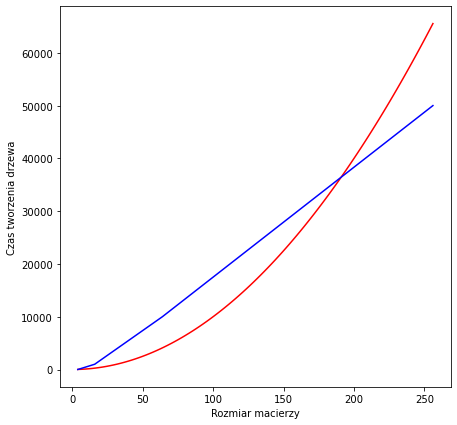

In [122]:
f = lambda x: 1*x**2 + 1

def compare_to_function(x, y, f):
    min_x = min(x)
    max_x = max(x)
    x_function = np.linspace(min_x, max_x, 100)
    y_function = list(map(f, x_function))
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    plt.plot(x_function, y_function, 'r-')
    plt.plot(x, y, 'b-')
    plt.xlabel('Rozmiar macierzy')
    plt.ylabel('Czas tworzenia drzewa')
    

compare_to_function([4, 16, 64, 256], [1, 1000, 10000, 50000], f)

### MSE

In [123]:
def mse(A, B):
    print(A - B)
    print(np.square(A - B))
    print()
    return np.sum(np.square(A - B))


### Tests

In [124]:
A = generate_matrix(128, 128, 0.5)
def compress(A, r, eps) -> TreeNode:
    return create_tree(A, 0, A.shape[0], 0, A.shape[1], r, eps)
    
node = compress(A, 1, 0.1)


In [125]:
print(A)

[[3 6 0 ... 0 0 5]
 [0 1 3 ... 7 5 7]
 [0 0 0 ... 0 2 0]
 ...
 [0 3 3 ... 0 0 3]
 [0 0 6 ... 5 0 1]
 [3 7 0 ... 0 0 0]]


In [126]:
decompose_tree(node)

array([[3., 6., 0., ..., 0., 0., 5.],
       [0., 1., 3., ..., 7., 5., 7.],
       [0., 0., 0., ..., 0., 2., 0.],
       ...,
       [0., 3., 3., ..., 0., 0., 3.],
       [0., 0., 6., ..., 5., 0., 1.],
       [3., 7., 0., ..., 0., 0., 0.]])

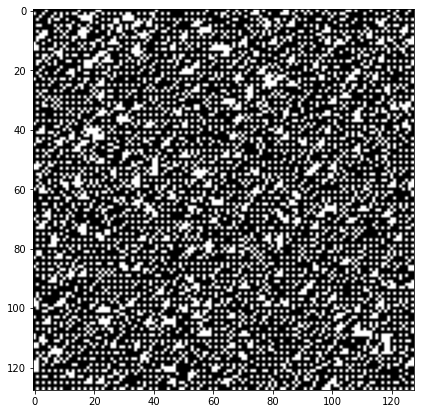

In [127]:
draw_tree(node)
